# Prediction of member type based on biking trip data

This is a notebook to study a biking data set obtained from
https://s3.amazonaws.com/capitalbikeshare-data/index.html .

The exercise was suggested on 
https://www.analyticsvidhya.com/blog/2018/05/24-ultimate-data-science-projects-to-boost-your-knowledge-and-skills/
under the title 'Trip history data set'.

Author of the notebook: Gustav Baardsen <br>
Date of first version: February 2019



In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import model
import keras.utils.np_utils as ks_utils

from sklearn.linear_model import LinearRegression
from model import BikingData

Using TensorFlow backend.


In [2]:
data_file = '2017Q1-capitalbikeshare-tripdata.csv'
data = BikingData(data_file)
data.print_categories()


Categories in the data:

  Duration
  Start station number
  End station number
  Bike number
  Member type



### Reading and preparation of data set
The data is read into a DataFrame object of the pandas library.

-  Assuming that the duration of the trip is more important than the start and end dates, the dates were dropped out from the data set. Because the data set contains IDs of the start and end stations, the station names are superfluous, and were therefore neglected.

-  Each time the DataFrame object is created, the samples of the data set are shuffled randomly using the function utils.shuffle() from the Scikit-Learn library.

-  Bike number and member type are converted to 'category' using the function astype() of the DataFrame class.

### Prediction task

Given start station, end station, bike number, and duration of the trip, the task is to predict the type of member. The member type is either 'Member' or 'Casual'.

In [3]:
input_data  = data.get_array()[:, :4]
output_data = data.get_array()[:, 4:5]

In [4]:
# Count the number of 'Member' and 'Casual'.
# 'Casual' is coded as 0 and 'Member' as 1.
n_total   = output_data.shape[0]
n_members = np.sum(output_data)
n_casual  = n_total - n_members
print('Number of members          :', 
      '{:>10}'.format(n_members), 
      '\nNumber of non-members      :', 
      '{:>10}'.format(n_casual))
print('Ratio non-members of total :', 
      '{0:15.4f}'.format(float(n_casual) / n_total))

Number of members          :     528434 
Number of non-members      :     118076
Ratio non-members of total :          0.1826


### Members vs. non-memebers

Here we can see that most of the data samples are associated with members. Still, the ratio of non-members is approximately 18 %.

Let us compute the average trip distance of members and non-members.

In [5]:
distances = data.get_array()[:, 0]
members = data.get_array()[:, -1].astype(bool)
casual  = (np.ones(n_total, dtype = int) - 
           members).astype(bool)

mean_distance_members = np.mean(distances[members])
mean_distance_casual = np.mean(distances[casual])
mean_distance_all = np.mean(distances)

print('Mean distance for members     :', 
      '{0:14.4f}'.format(mean_distance_members))
print('Mead distance for non-members :', 
      '{0:14.4f}'.format(mean_distance_casual))
print('Mean distance for all bikers  :', 
      '{0:14.4f}'.format(mean_distance_all))

Mean distance for members     :       689.8325
Mead distance for non-members :      2445.3049
Mean distance for all bikers  :      1010.4449


### Mean distances of members and non-memebers

As seen above, in average, members do shorter trips than non-members. Knowing that 'Casual' is coded as 0 and 'Member' as 1, this is in agreement with the negative correlation between distance and member type seen in the printout of the covariance matrix below. 


Covariance matrix for the data:

 1.0000E+00 -1.1554E-02 -1.5248E-02  1.7751E-03 -3.2499E-01 
-1.1554E-02  1.0000E+00  5.1510E-01  1.5367E-02  5.2161E-02 
-1.5248E-02  5.1510E-01  1.0000E+00  1.5208E-02  5.8695E-02 
 1.7751E-03  1.5367E-02  1.5208E-02  1.0000E+00  6.8194E-03 
-3.2499E-01  5.2161E-02  5.8695E-02  6.8194E-03  1.0000E+00 



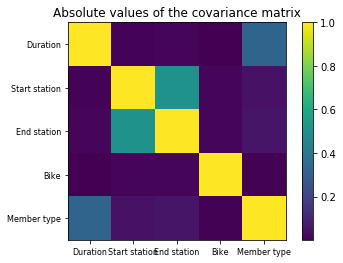

In [6]:
# Plot the covariance matrix between the variables
model.plot_covariance(data.get_array())

### What the covariance matrix tells us...

According to the covariance matrix of the five variables, the start and end stations are most clearly correlated. This is of course expected. In addition, one can see a correlation between the duration of the bike trip and the type of member. As we found above, in average, non-members go on longer biking trips than members do.

Because the standard deviations are normalized to one, the covariance matrix elements are also correlation factors of the considered set of variables.

### Using the data in learning methods

When using a neural network for a prediction task, it is common to divide the total data set into partitions for training, development, and testing. This we will do below.

Furthermore, we chose to represent the member data of each sample using two integers. For example, if the sample corresponds to a 'Member', then the member data of that sample is [0, 1], whereas a 'Casual' is denoted by [1, 0].

In [7]:
output_data_c = ks_utils.to_categorical(output_data,
                                        num_classes = 2)

In [8]:
# Partition the data set into training, development,
# and test sets. The input and output data are also
# normalized.
input_train, input_dev, input_test, \
    output_train, output_dev, output_test = \
        model.get_train_test_dev_sets(input_data,
                                        output_data_c)


Size of training set     :                517208
Size of development set  :                128655
Size of test set         :                   647 



### Linear regression

As the most straightforward prediction approach, we classify biking data samples using linear regression and a least-squares error functional. This is done using the LinearRegression class from Scikit-Learn.

In the linear regression, each member type is represented by a single integer: 0 for 'Casual' and 1 for 'Member'. A linear-regression prediction with a value larger than 0.5 is classified as 'Member' and the rest are classified as 'Casual'.

The training set is used for the linear fitting, whereas the development set is used to test the prediction based on linear regression.

In [9]:
regressor = LinearRegression()
regressor.fit(input_train,
            output_train[:, 1])
output_linreg = regressor.predict(input_dev)
    
# Accuracy of prediction
predictions_reg = \
    model.classify_from_float_0_1(output_linreg)
output_members_dev = \
    output_dev[:, 1].astype(int)
accuracy = model.ratio_same_value(predictions_reg,
                                    output_members_dev)
print('\nClassification accuracy of linear regression:',
        '{0:14.4f}'.format(accuracy))


Classification accuracy of linear regression:         0.8284


### The prediction power of the linear regressor

Here the linear-regression classifier predicts correctly for approximately 82 % of the samples. 

Above we found that the ratio of samples with member type 'Casual' is around 18 %. Assuming the same distribution of 'Member' vs. 'Casual' in the development set, a performance equally good as the linear-regression classifier would have been obtained by just assuming that all samples are of type 'Member'.

In fact, that is also what we see in the analysis below: In the linear-regression classification, only around 1 % of the samples are predicted as being non-member. This is far from the true ratio, which is around 18 %. Also, only about 7 % of the real non-members were classified as non-member.

Therefore, the classification accuracy of the linear regressor is not good, and we would like to find a better predictor.

In [10]:
model.analyse_output_ratios(predictions_reg,
                              output_members_dev)


Number of samples predicted as member     :     126816
Number of samples predicted as non-member :       1839

True ratio      (non-members / all) :         0.1833
Predicted ratio (non-members / all) :         0.0143

Ratio of members that were correctly predicted as members:
         0.9984

Ratio of non-members that were correctly predicted as non-member:
         0.0708 



### A neural network for the classification task

Because the linear regressor did not perform satisfactorily, let us try solving the classification problem using a neural network. 

We construct the neural network using the libraries Tensorflow and Keras.

-  The neural network is constructed by $N-1$ layers with a RelU activation function and a last layer with a Softmax activation.
-  The loss function is losses.softmax_cross_entropy from Tensorflow.
-  Adam's algorithm is used for the optimization.

The softmax activation in the last layer was chosen because it can be interpreted as giving probabilities, which is suitable for the classification task we have, with two possible output classes.

In [11]:
# Create a neural-network predictor object
analyser = model.NNPredictor(input_train,
                            input_dev,
                            input_test,
                            output_train,
                            output_dev,
                            output_test)

First, we test a neural network in with four layers, in which the three first contains four neurons each. The batch size is chosen to be 500, which is quite large, and we start by using no regularization. 

In [12]:
opt_algorithm   = 'adam'
loss_function   = tf.losses.softmax_cross_entropy
error_metrics   = ['accuracy']
n_per_layer     = [4, 4, 4]
n_iterations    = 4
n_batch         = 500
reg_parameters  = [0.0, 0.0]
    
print('Next, a neural network is trained...')
analyser.train_network(optimization = opt_algorithm,
                        loss = loss_function,
                        metrics = error_metrics,
                        n_neurons = n_per_layer,
                        n_mainloop = n_iterations,
                        batch_size = n_batch,
                        reg_params = reg_parameters)

Next, a neural network is trained...
Epoch 1/4
517208/517208 [==============================] - 3s 5us/step - loss: 0.5082 - acc: 0.7991
Epoch 2/4
517208/517208 [==============================] - 3s 5us/step - loss: 0.4509 - acc: 0.8628
Epoch 3/4
517208/517208 [==============================] - 3s 5us/step - loss: 0.4368 - acc: 0.8817
Epoch 4/4
517208/517208 [==============================] - 3s 7us/step - loss: 0.4315 - acc: 0.8827


### Validation

Let us test the performance of this neural network on the development data set.

128655/128655 [==============================] - 3s 20us/step

Error in the development set:

Loss: 0.4300599549123935
Accuracy: 0.8821887995030089 



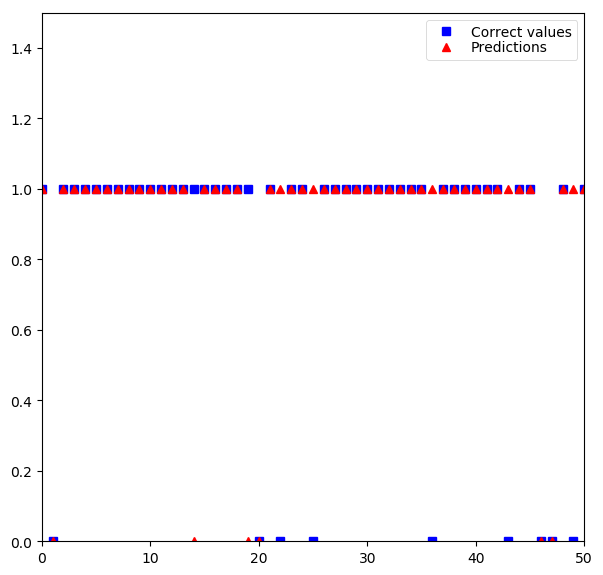

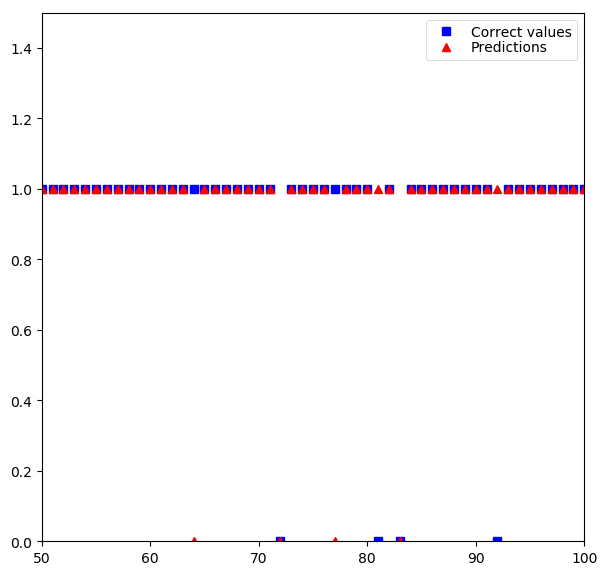

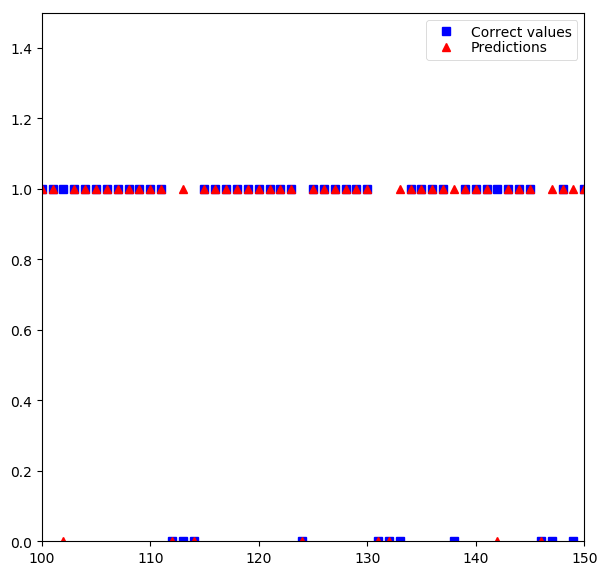

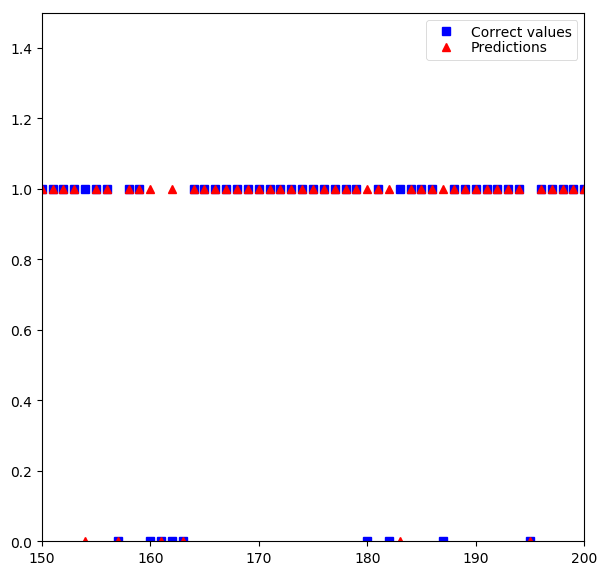

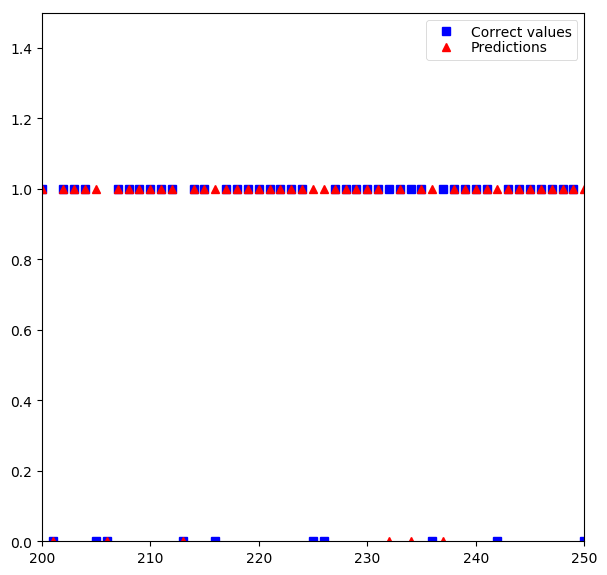

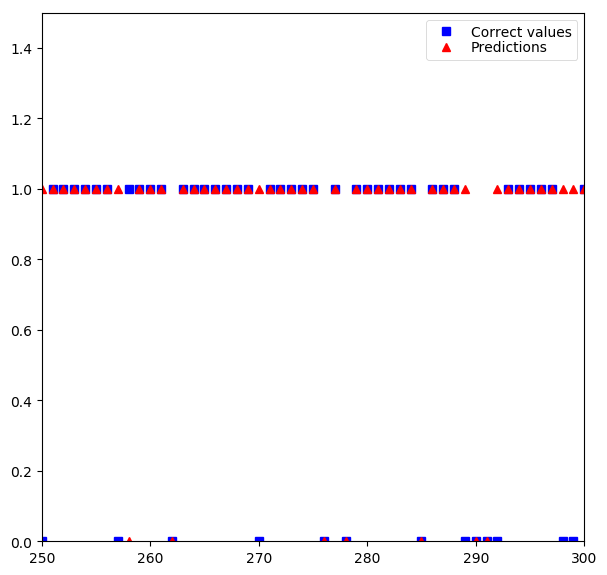

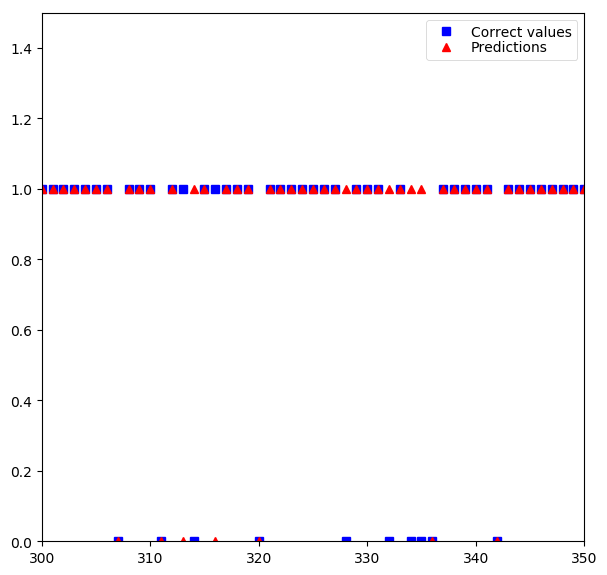

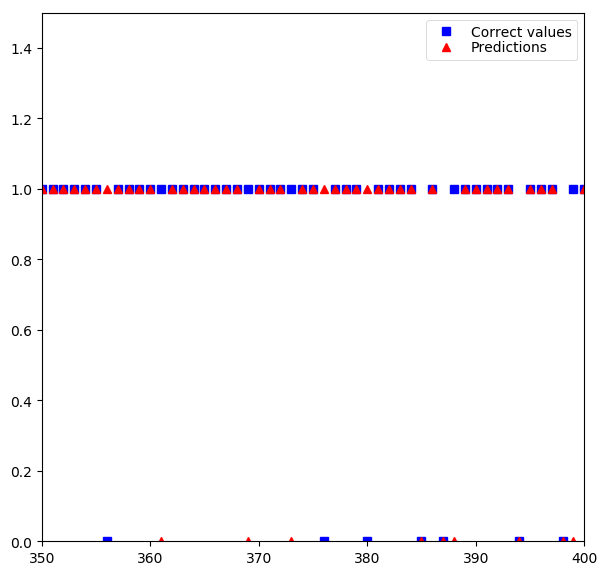

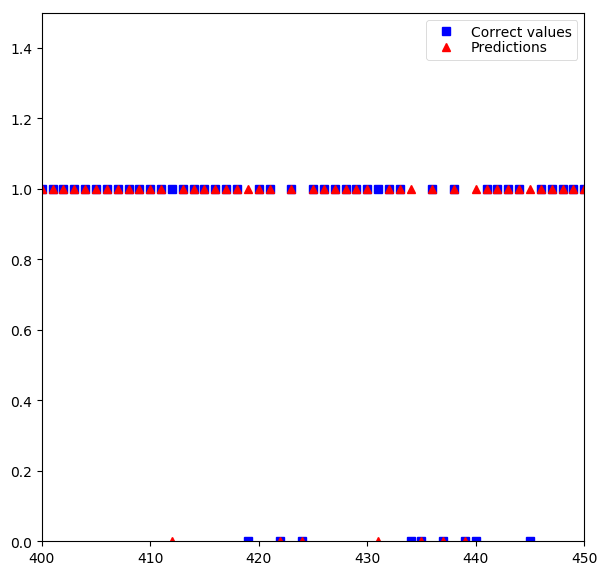

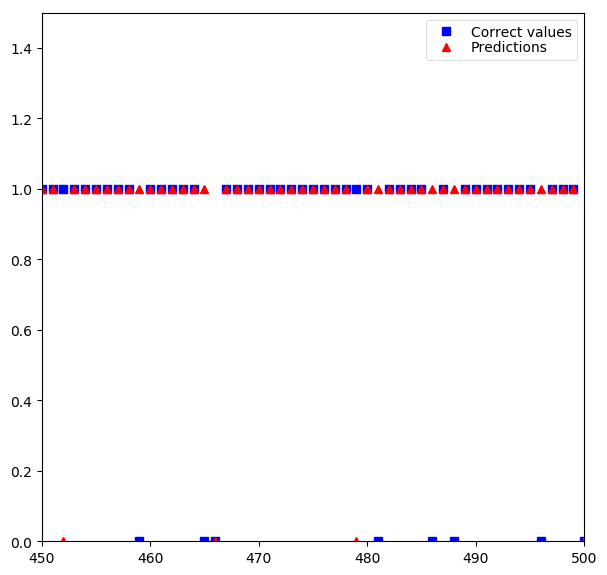

In [13]:
make_plots = True
analyser.validate(analyser.in_dev,
                 analyser.out_dev,
                 plot = make_plots)

### Analysis of the first neural-network results

The classification accuracy has now improved to 88 %. This is clearly better than what would have been obtained by assuming that all samples are associated with a member.

To understand the performance of the neural network better, we analyse the classification result of the neural network in a similar way as we did above for the linear regressor.

In [14]:
# Array containing ones for 'Member' and zeros for 'Casual'
predicted_members = \
    analyser.get_predictions(analyser.in_dev)

model.analyse_output_ratios(predicted_members,
                              output_members_dev)


Number of samples predicted as member     :     113663
Number of samples predicted as non-member :      14992

True ratio      (non-members / all) :         0.1833
Predicted ratio (non-members / all) :         0.1165

Ratio of members that were correctly predicted as members:
         0.9687

Ratio of non-members that were correctly predicted as non-member:
         0.4965 



### Analysis of the first neural-network results continues...

These results look considerably better than what was obtained with the linear regressor. Now 49 % of real non-members are correctly classified as non-members. The error in the prediction of real members is slightly worse, but the ratio of members that were correctly predicted as members is still 97 %.

Because the classification accuracy on the development set is almost equal to the accuracy on the test set, overfitting does not seem to be a big problem. 

When using the test set, the classification accuracy is almost unchanged:

In [15]:
analyser.validate(analyser.in_test,
                 analyser.out_test)

647/647 [==============================] - 0s 54us/step

Error in the development set:

Loss: 0.4247209914316534
Accuracy: 0.8902627511591963 



### A training set with (members / non-members) (50 / 50)

In the original training set, the share of non-members is only about 18 %. With the neural network used above, less than 50 % of real non-members in the development set were predicted as being non-members, where as the corresponding number for members was 97 %. 

As an effort to try to improve the prediction of non-members, we will train the same neural network using an equal amount of members and non-members.

In [16]:
input_train_50, output_train_50 = \
    model.split_data_5050(input_train, output_train)

In [17]:
# Create a neural-network predictor object
analyser = model.NNPredictor(input_train_50,
                            input_dev,
                            input_test,
                            output_train_50,
                            output_dev,
                            output_test)

In [18]:
opt_algorithm   = 'adam'
loss_function   = tf.losses.softmax_cross_entropy
error_metrics   = ['accuracy']
n_per_layer     = [4, 4, 4]
n_iterations    = 4
n_batch         = 500
reg_parameters  = [0.0, 0.0]
    
print('Next, a neural network is trained...')
analyser.train_network(optimization = opt_algorithm,
                        loss = loss_function,
                        metrics = error_metrics,
                        n_neurons = n_per_layer,
                        n_mainloop = n_iterations,
                        batch_size = n_batch,
                        reg_params = reg_parameters)

Next, a neural network is trained...
Epoch 1/4
188758/188758 [==============================] - 1s 7us/step - loss: 0.6303 - acc: 0.6750
Epoch 2/4
188758/188758 [==============================] - 1s 5us/step - loss: 0.5509 - acc: 0.7546
Epoch 3/4
188758/188758 [==============================] - 1s 5us/step - loss: 0.5330 - acc: 0.7690
Epoch 4/4
188758/188758 [==============================] - 1s 5us/step - loss: 0.5300 - acc: 0.7704


In [19]:
analyser.validate(analyser.in_dev,
                 analyser.out_dev)

128655/128655 [==============================] - 5s 38us/step

Error in the development set:

Loss: 0.4967341118036605
Accuracy: 0.8140064513649499 



In [20]:
# Array containing ones for 'Member' and zeros for 'Casual'
predicted_members = \
    analyser.get_predictions(analyser.in_dev)

model.analyse_output_ratios(predicted_members,
                              output_members_dev)


Number of samples predicted as member     :      95185
Number of samples predicted as non-member :      33470

True ratio      (non-members / all) :         0.1833
Predicted ratio (non-members / all) :         0.2602

Ratio of members that were correctly predicted as members:
         0.8391

Ratio of non-members that were correctly predicted as non-member:
         0.7023 



### Comments on the training using a 50 / 50 split

With the 50 / 50 split between members and non-members in the training set, the ratio of non-members that were correctly prediced as non-members improved from less than 0.5 to 0.7. However, the overall prediction accuracy decreased from 0.88 to 0.82.

Let us now try a new training with a deeper network with more layers and neurons per layer. As seen below, this does not improve the performance.

In [21]:
opt_algorithm   = 'adam'
loss_function   = tf.losses.softmax_cross_entropy
error_metrics   = ['accuracy']
n_per_layer     = [8, 8, 8, 8, 8]
n_iterations    = 5
n_batch         = 500
reg_parameters  = [0.0, 0.0]
    
print('Next, a neural network is trained...')
analyser.train_network(optimization = opt_algorithm,
                        loss = loss_function,
                        metrics = error_metrics,
                        n_neurons = n_per_layer,
                        n_mainloop = n_iterations,
                        batch_size = n_batch,
                        reg_params = reg_parameters)

Next, a neural network is trained...
Epoch 1/5
188758/188758 [==============================] - 2s 12us/step - loss: 0.6050 - acc: 0.7139
Epoch 2/5
188758/188758 [==============================] - 2s 11us/step - loss: 0.5267 - acc: 0.7776
Epoch 3/5
188758/188758 [==============================] - 2s 8us/step - loss: 0.5214 - acc: 0.7808
Epoch 4/5
188758/188758 [==============================] - 1s 7us/step - loss: 0.5196 - acc: 0.7826
Epoch 5/5
188758/188758 [==============================] - 1s 7us/step - loss: 0.5185 - acc: 0.7840


In [22]:
analyser.validate(analyser.in_dev,
                 analyser.out_dev)

128655/128655 [==============================] - 6s 48us/step

Error in the development set:

Loss: 0.4736034485505365
Accuracy: 0.8352415374469583 



### About overlapping data

From the analysis above, we see that it is hard to discriminate between members and non-members with a high precision.

From the covariance matrix, we saw that the trip duration is the variable that is most strongly correlated with the member type. When it is so hard to classification to a precision above 0.9, one may ask whether overlapping data for the two types of members may be the reason. 

For example, it is not unreasonable to guess that many of the non-members do trips of similar duration, between the same stations, and with the same bike as members often do. To find out of whether such an overlap of data is occuring, below we plot a histogram of trip durations for members and non-members.

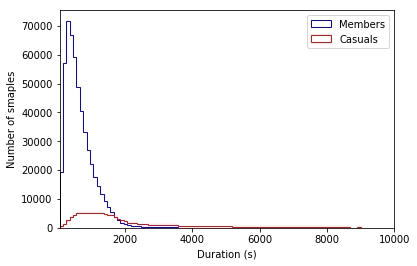

In [23]:
data.plot_histogram('Duration',
                   max_x = 10000)

In [24]:
durations_members = data.get_values('Duration',
                                   'Member')
durations_casuals = data.get_values('Duration',
                                   'Casual')

print('Ratio of members and non-members that took a trip ' + \
      'that lasted more\nthan 45 minutes\n')
print('Members     :', 
      '{0:14.4f}'.format(np.sum(durations_members > 2700) / \
      float(durations_members.shape[0])))
print('Non-members :',
      '{0:14.4f}'.format(np.sum(durations_casuals > 2700) / \
      float(durations_casuals.shape[0])))

Ratio of members and non-members that took a trip that lasted more
than 45 minutes

Members     :         0.0074
Non-members :         0.2512


### Overlap between durations

The histogram above shows that approximately 75 % of the non-member bike trips have a duration that is also a typical duration for the trip of a member. Therefore, based on the duration alone, it is very hard to distinguish members and non-members.

Of course, in a neural network, more complex nonlinear relations between the different variables are taken into account.

Next, we plot similar histograms for the start station, end station, and bike ID.

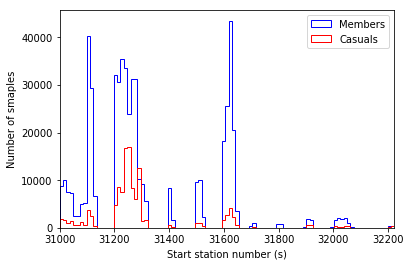

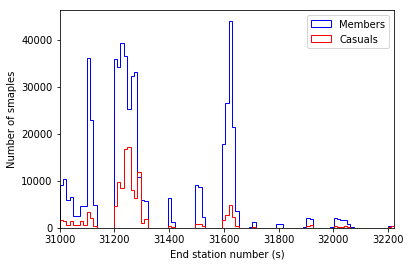

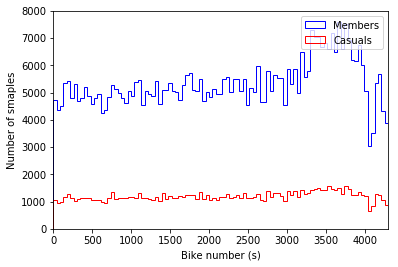

In [26]:
data.plot_histogram('Start station number')
data.plot_histogram('End station number')
data.plot_histogram('Bike number')